## Imports y datasets

Importamos librerias y funciones a utilizar.

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

import pickle

Seteamos una semilla para que los resultados sean reproducibles.

In [62]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE) 

Importamos los datasets a utilizar y los guardamos en variables.

In [63]:
test = pd.read_csv('Datasets/test_encoded.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
original = pd.read_csv('Datasets/hotels_procesado.csv')
original_test = pd.read_csv('Datasets/hotels_test.csv')

## Normalizacion y split de datasets

Normalizamos los datos a utilizar.

In [64]:
stand_scaler = StandardScaler()
train = stand_scaler.fit_transform(train)
test = stand_scaler.transform(test)

Separamos los datos en train y test cvon una proporcion de 70/30

In [65]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

Ahora vamos a variar parámetros creando 3 modelos distintos para ver cual da mejores resultados.

## Modelo 1

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [66]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [67]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [68]:
modelo_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                11008     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [69]:
epochs = 256

In [79]:
modelo_1.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.1),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = modelo_1.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/256
582/582 [==============================] - 5s 7ms/step - loss: 0.5598 - accuracy: 0.6893 - val_loss: 0.6673 - val_accuracy: 0.6757
Epoch 2/256
582/582 [==============================] - 3s 4ms/step - loss: 0.6424 - accuracy: 0.5901 - val_loss: 0.6671 - val_accuracy: 0.5449
Epoch 3/256
582/582 [==============================] - 3s 5ms/step - loss: 0.6699 - accuracy: 0.5395 - val_loss: 0.6840 - val_accuracy: 0.4913
Epoch 4/256
582/582 [==============================] - 3s 5ms/step - loss: 0.6911 - accuracy: 0.5261 - val_loss: 0.6936 - val_accuracy: 0.4913
Epoch 5/256
582/582 [==============================] - 2s 4ms/step - loss: 0.6944 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.5087
Epoch 6/256
582/582 [==============================] - 2s 4ms/step - loss: 0.6949 - accuracy: 0.4965 - val_loss: 0.7025 - val_accuracy: 0.4913
Epoch 7/256
582/582 [==============================] - 2s 3ms/step - loss: 0.6949 - accuracy: 0.5025 - val_loss: 0.6957 - val_accuracy: 0.4913

En el siguiente gráfico podemos ver como varía el error por epoch:

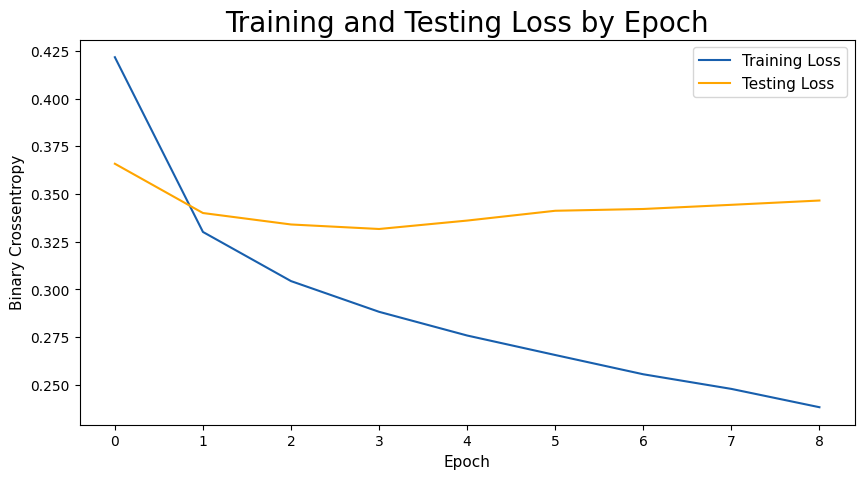

In [71]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

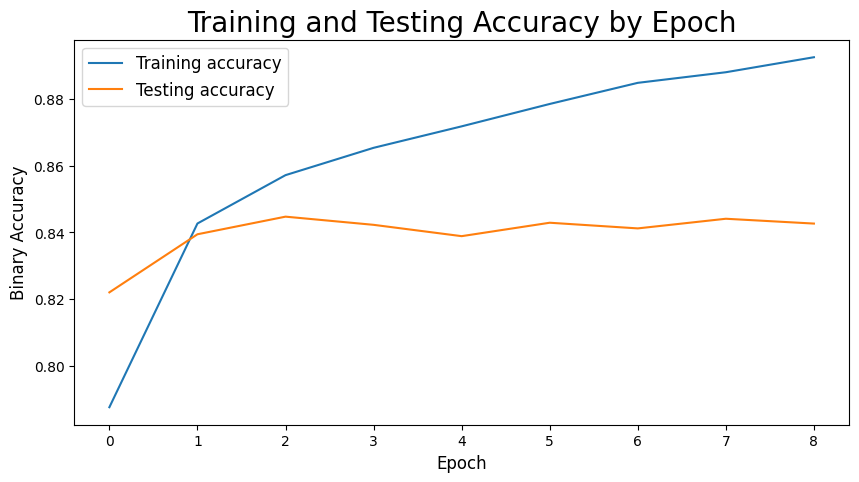

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

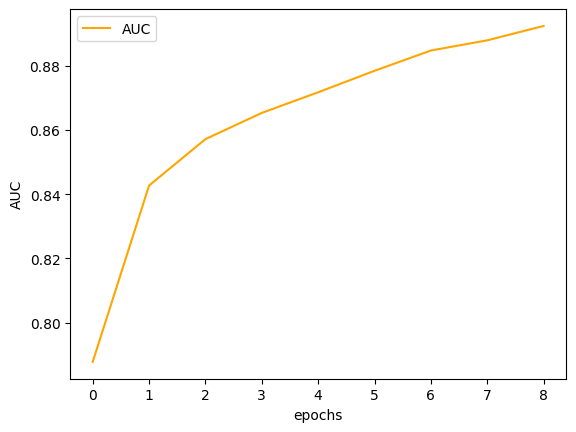

In [73]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [74]:
train_score = modelo_1.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_1.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_1.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 1ms/step - loss: 0.3466 - accuracy: 0.8427

Training Accuracy: 0.906028151512146
Testing Accuracy: 0.8426599502563477


In [75]:
y_pred = modelo_1.predict(x_test)

499/499 [==============================] - 1s 1ms/step


In [76]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8382057716436637
Recall: 0.8851751356684756
Precision: 0.813257790368272
f1 score: 0.8476938522411859


In [77]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      7832
           1       0.81      0.89      0.85      8108

    accuracy                           0.84     15940
   macro avg       0.84      0.84      0.84     15940
weighted avg       0.84      0.84      0.84     15940



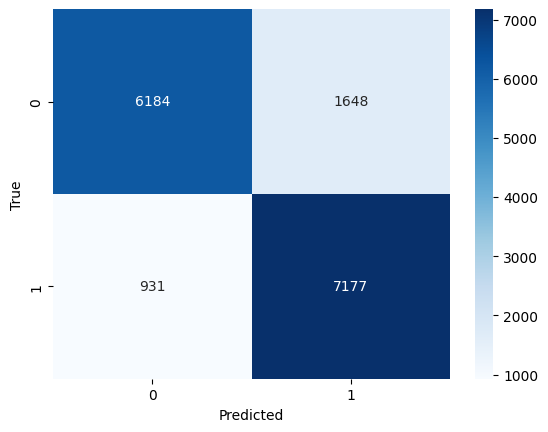

In [78]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 2

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [80]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [81]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [82]:
modelo_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                11008     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [83]:
epochs = 100

In [84]:
modelo_2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision()] 
    )

history = modelo_2.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/100
582/582 [==============================] - 4s 5ms/step - loss: 0.5987 - accuracy: 0.6605 - precision: 0.6751 - val_loss: 0.5129 - val_accuracy: 0.7361 - val_precision: 0.7538
Epoch 2/100
582/582 [==============================] - 2s 4ms/step - loss: 0.4655 - accuracy: 0.7662 - precision: 0.7871 - val_loss: 0.4392 - val_accuracy: 0.7784 - val_precision: 0.8106
Epoch 3/100
582/582 [==============================] - 2s 4ms/step - loss: 0.4148 - accuracy: 0.7936 - precision: 0.8068 - val_loss: 0.4124 - val_accuracy: 0.7990 - val_precision: 0.8154
Epoch 4/100
582/582 [==============================] - 2s 4ms/step - loss: 0.3930 - accuracy: 0.8061 - precision: 0.8142 - val_loss: 0.3997 - val_accuracy: 0.8082 - val_precision: 0.8123
Epoch 5/100
582/582 [==============================] - 2s 4ms/step - loss: 0.3797 - accuracy: 0.8136 - precision: 0.8187 - val_loss: 0.3936 - val_accuracy: 0.8110 - val_precision: 0.8007
Epoch 6/100
582/582 [==============================] - 3s 5ms/ste

En el siguiente gráfico podemos ver como varía el error por epoch:

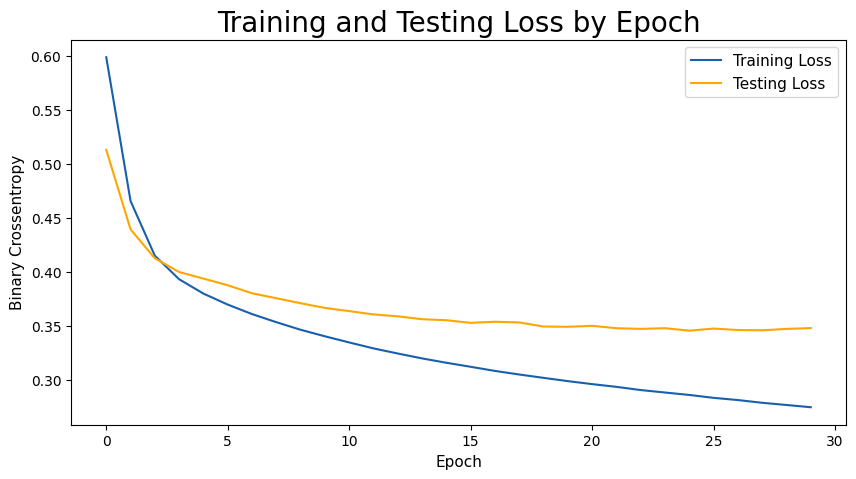

In [85]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

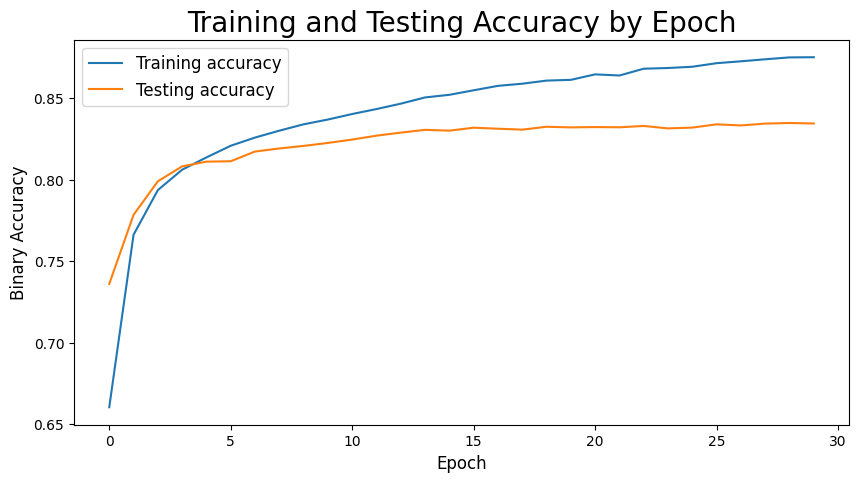

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

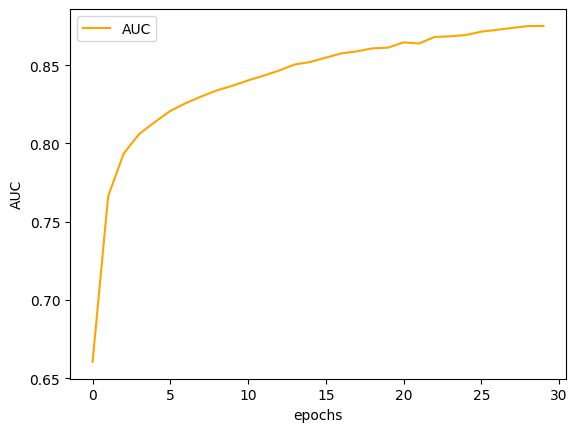

In [87]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [88]:
train_score = modelo_2.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_2.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_2.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 1s 2ms/step - loss: 0.3478 - accuracy: 0.8344 - precision: 0.8339

Training Accuracy: 0.8808614611625671
Testing Accuracy: 0.8344416618347168


In [89]:
y_pred = modelo_2.predict(x_test)

499/499 [==============================] - 2s 3ms/step


In [90]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8301756587202007
Recall: 0.8923285643808584
Precision: 0.7977726320432241
f1 score: 0.8424055422949291


In [91]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      7832
           1       0.80      0.89      0.84      8108

    accuracy                           0.83     15940
   macro avg       0.84      0.83      0.83     15940
weighted avg       0.83      0.83      0.83     15940



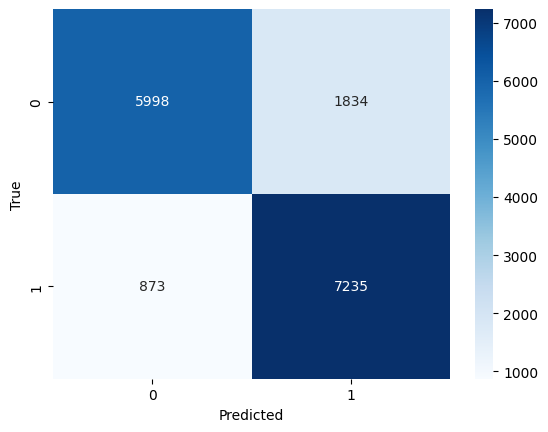

In [92]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelo 3

Seteamos la cantidad de capas, neuronas por capa y funcion de activacion.

In [93]:
cant_clases = len(np.unique(y_train))
cant_inputs = len(train[0])

modelo_1 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[cant_inputs]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Vamos a utilizar EarlyStopping como funcion de regularizacion para evitar el overfitting.

In [94]:
es = EarlyStopping(monitor='val_loss', patience=5) 

Acá podemos ver un resumen del modelo.

In [95]:
modelo_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                11008     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________


Seteamos parámetros para este primer modelo: cantidad de epochs y optimizador a utilizar, y luego entrenamos el modelo

In [96]:
epochs = 256

In [97]:
modelo_1.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
    )

history = modelo_1.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data = (x_test, y_test), callbacks=[es])

Epoch 1/256
582/582 [==============================] - 5s 6ms/step - loss: 0.4101 - accuracy: 0.7927 - val_loss: 0.3575 - val_accuracy: 0.8272
Epoch 2/256
582/582 [==============================] - 4s 6ms/step - loss: 0.3269 - accuracy: 0.8414 - val_loss: 0.3354 - val_accuracy: 0.8385
Epoch 3/256
582/582 [==============================] - 4s 7ms/step - loss: 0.3025 - accuracy: 0.8559 - val_loss: 0.3309 - val_accuracy: 0.8418
Epoch 4/256
582/582 [==============================] - 5s 9ms/step - loss: 0.2866 - accuracy: 0.8669 - val_loss: 0.3289 - val_accuracy: 0.8408
Epoch 5/256
582/582 [==============================] - 6s 10ms/step - loss: 0.2730 - accuracy: 0.8721 - val_loss: 0.3328 - val_accuracy: 0.8388
Epoch 6/256
582/582 [==============================] - 5s 8ms/step - loss: 0.2631 - accuracy: 0.8779 - val_loss: 0.3400 - val_accuracy: 0.8418
Epoch 7/256
582/582 [==============================] - 4s 7ms/step - loss: 0.2529 - accuracy: 0.8839 - val_loss: 0.3358 - val_accuracy: 0.843

En el siguiente gráfico podemos ver como varía el error por epoch:

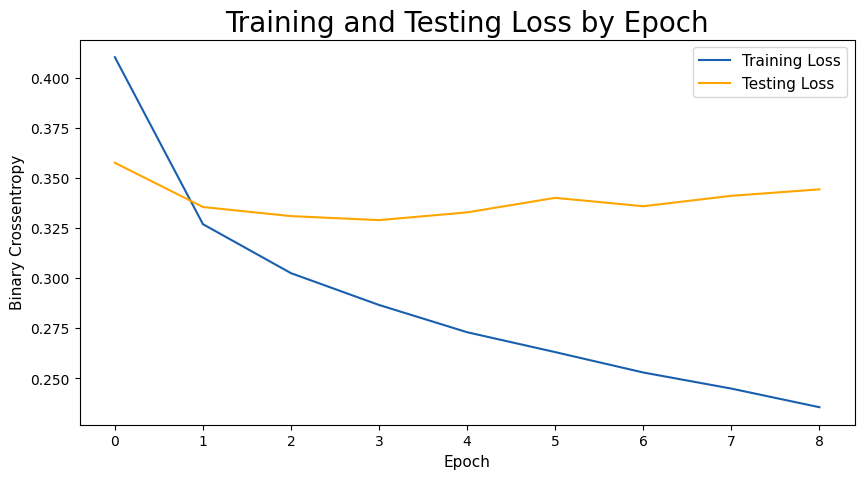

In [98]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11)

Acá podemos ver como varía el accuracy por epoch:

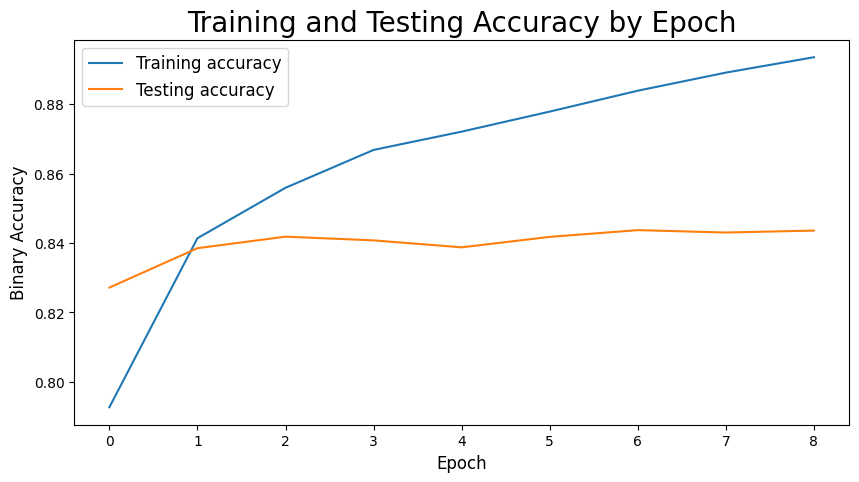

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accuracy by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

En el siguiente gráfico se puede ver el area bajo la curva:

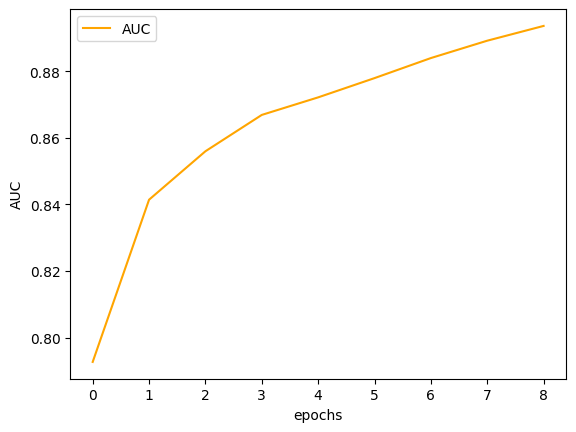

In [100]:
plt.plot(history.history['accuracy'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

In [101]:
train_score = modelo_1.evaluate(x_train,
                       y_train,
                       verbose=1)
test_score = modelo_1.evaluate(x_test,
                       y_test,
                       verbose=1)
labels = modelo_1.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

499/499 [==============================] - 2s 3ms/step - loss: 0.3443 - accuracy: 0.8436

Training Accuracy: 0.9068616628646851
Testing Accuracy: 0.8436009883880615


In [102]:
y_pred = modelo_1.predict(x_test)

499/499 [==============================] - 1s 2ms/step


In [103]:
y_pred_binario = np.where(y_pred > 0.3851, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binario)
recall = recall_score(y_test, y_pred_binario)
f1 = f1_score(y_test, y_pred_binario,)
precision = precision_score(y_test, y_pred_binario)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8400878293601004
Recall: 0.8931919092254563
Precision: 0.8114285714285714
f1 score: 0.8503493219045383


In [104]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred_binario))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      7832
           1       0.81      0.89      0.85      8108

    accuracy                           0.84     15940
   macro avg       0.84      0.84      0.84     15940
weighted avg       0.84      0.84      0.84     15940



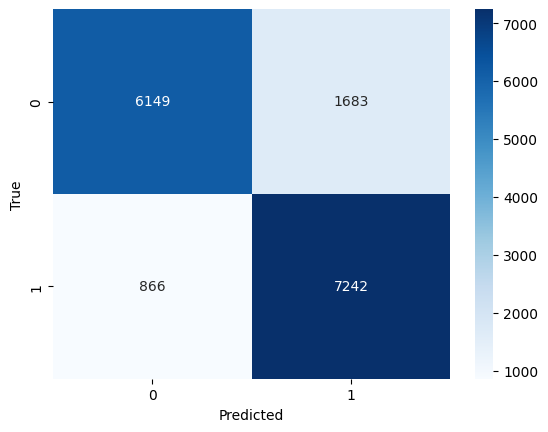

In [105]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_binario)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Submission

In [106]:
pickle.dump(modelo, open('neural_network_grupo29.pickle', 'wb'))

In [107]:
X_submission = test
y_pred_test = modelo.predict(X_submission)
y_pred_test_binario = np.where(y_pred_test > 0.3851, 1, 0)

830/830 [==============================] - 2s 3ms/step


In [108]:
df_submission = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_binario.flatten()})
df_submission.to_csv('nn00.csv', index=False)